# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
# библиотеки для работы с данными
import pandas as pd
import numpy as np
from scipy.stats import randint

# библиотеки для графиков
import seaborn as sns
import matplotlib.pyplot as plt

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   MinMaxScaler)
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загрузим модели
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

# импорт MSE
from sklearn.metrics import root_mean_squared_error, make_scorer

# библиотека для корреляционной матрицы и проверки на мультиколлинеарность
from phik.report import plot_correlation_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor

#импорт Shap для объяснения интерпретации модели
import shap

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка данных

### Загрузка и изучение данных

In [3]:
df = pd.read_csv('autos.csv')

In [4]:
# Улучшенная функция для основной информации о датафрейме
def data_exploration(dataframe):
    print('\033[1m' + 'Информация о датафрейме:')
    print('\033[0m')
    dataframe.info()
    
    print('\033[1m' + 'Первые пять строк:')
    print('\033[0m')
    display(dataframe.head())
    
    print('\033[1m' + 'Статистическое описание данных:')
    print('\033[0m')
    display(dataframe.describe())
    
    print('\033[1m' + 'Количество уникальных значений:')
    print('\033[0m')
    display(dataframe.nunique())
    
    print('\033[1m' + 'Пропуски в данных:')
    print('\033[0m')
    missing = dataframe.isna().sum()
    missing = missing[missing > 0]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing.index, y=missing.values)
    plt.title('Количество пропущенных значений по столбцам')
    plt.xticks(rotation=45)
    plt.show()
    
    print('\033[1m' + 'Количество дубликатов:')
    print('\033[0m')
    print(dataframe.duplicated().sum())

Информация о датафрейме:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Статистическое описание данных:



,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество уникальных значений:



DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
Repaired                  2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

Пропуски в данных:



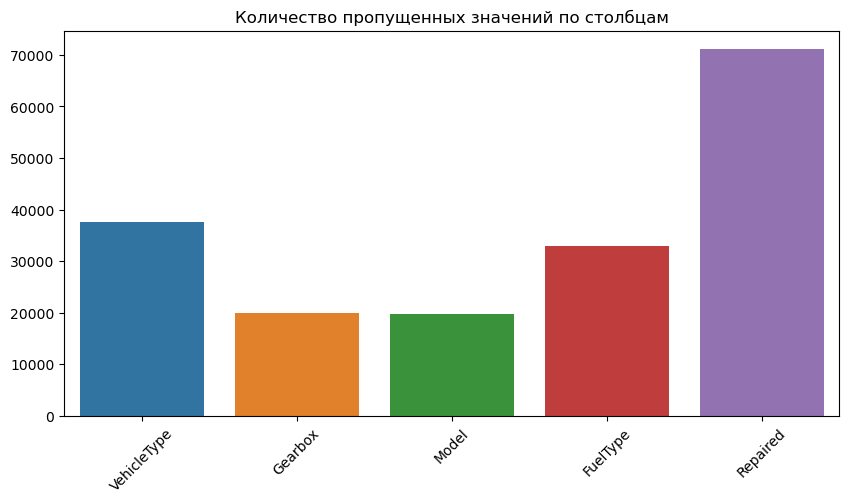

Количество дубликатов:

4


In [5]:
data_exploration(df)

#### Итоги загрузки и первичного изучения данных: 

- Всего 354369 строк

__Признаки:__

- __DateCrawled__ — дата скачивания анкеты из базы
- __VehicleType__ — тип автомобильного кузова
- __RegistrationYear__ — год регистрации автомобиля
- __Gearbox__ — тип коробки передач
- __Power__ — мощность (л. с.)
- __Model__ — модель автомобиля
- __Kilometer__ — пробег (км)
- __RegistrationMonth__ — месяц регистрации автомобиля
- __FuelType__ — тип топлива
- __Brand__ — марка автомобиля
- __Repaired__ — была машина в ремонте или нет
- __DateCreated__ — дата создания анкеты
- __NumberOfPictures__ — количество фотографий автомобиля
- __PostalCode__ — почтовый индекс владельца анкеты (пользователя)
- __LastSeen__ — дата последней активности пользователя

__Целевой признак:__
- __Price — цена (евро)__

__Выбросы, пропуски и дубликаты:__
- NumberOfPictures состоит из нулевых значений, столбец не несет информационной важности
- Замечены аномалии RegistrationYear, Power
- Пропуски данных в столбцах VehicleType, Gearbox, Model, FuelType, Repaired
- 4 полных дубликата

### Ручная предобработка данных 

Проведем ручную предобработку данных, часть предобратоки проведем в pipeline 

#### Устранение дубликатов

In [6]:
#Уберем дубликаты
df = df.drop_duplicates()
df.duplicated().sum()

0

4 дубликаты устранено

#### Создание признака lifetime на основе малоинформативных данных

В ходе первичного анализа были замечены аномальные годы регистрации авто. Устраним эти аномалии и сделаем новый признак из данных. 

In [7]:
#Изучим кол-во аномальных значений
display(df[df['RegistrationYear'] <= 1960].head())
print(df[df['RegistrationYear'] <= 1960].count())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25 00:00:00,0,58135,2016-03-25 15:58:21
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15 00:00:00,0,79288,2016-04-07 05:15:34
3333,2016-03-15 21:36:20,10500,sedan,1955,manual,30,other,60000,0,petrol,ford,NaN,2016-03-15 00:00:00,0,53498,2016-04-07 08:16:11


DateCrawled          610
Price                610
VehicleType          350
RegistrationYear     610
Gearbox              308
Power                610
Model                326
Kilometer            610
RegistrationMonth    610
FuelType             337
Brand                610
Repaired             246
DateCreated          610
NumberOfPictures     610
PostalCode           610
LastSeen             610
dtype: int64


In [8]:
#Оставим только машины которые после 1960 и до 2016 года 
df = df[(df['RegistrationYear'] >= 1960) & (df['RegistrationYear'] <= 2016)]

In [9]:
# Преобразование столбца DateCreated в формат datetime
df['DateCreated'] = pd.to_datetime(df['DateCreated'])

# Обработка RegistrationMonth: если месяц равен 0, заменить его на 1 (предположим, что 0 означает январь)
df['RegistrationMonth'] = df['RegistrationMonth'].replace(0, 1)

# Создание столбца RegistrationDate на основе RegistrationYear и RegistrationMonth
df['RegistrationDate'] = pd.to_datetime(df['RegistrationYear'].astype(str) + '-' + df['RegistrationMonth'].astype(str) + '-01')

# Вычисление lifetime в годах
df['Lifetime'] = (df['DateCreated'] - df['RegistrationDate']).dt.total_seconds() / (365.25 * 24 * 3600)

# Список признаков для удаления
columns_to_drop = ['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'RegistrationMonth', "Brand", 'RegistrationYear', 'NumberOfPictures', 'RegistrationDate']

# Удаление признаков
df = df.drop(columns=columns_to_drop)

#Изучим новый датафрейм с измениями
df.head()

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Repaired,Lifetime
0,480,NaN,manual,0,golf,150000,petrol,NaN,23.225188
1,18300,coupe,manual,190,NaN,125000,gasoline,yes,4.898015
2,9800,suv,auto,163,grand,125000,gasoline,NaN,11.616701
3,1500,small,manual,75,golf,150000,petrol,no,14.792608
4,3600,small,manual,69,fabia,90000,gasoline,no,7.748118


__Результаты предобработки:__
- Убрано 4 дубликата
- Оставили только машины которые после 1960 и до 2021 года 
- Убрали признаки 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'RegistrationMonth', "Brand", 'RegistrationYear', 'NumberOfPictures', 'RegistrationDate' 

### Анализ числовых признаков

In [10]:
numerical_columns_eda = df.select_dtypes(include=['number'], exclude=['object']).columns.tolist()
categoric_columns_eda = df.select_dtypes(include=['object'], exclude=['number']).columns.tolist()

In [11]:
# Функция для вычисления нижнего и верхнего пределов для определения выбросов
def outlier_detection(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range


# Функция для вывода анализа количественных данных
def plot_numerical_features(dataframe, features):
    for feature in features:
        if feature != 'id' and pd.api.types.is_numeric_dtype(dataframe[feature]):
            #Построение гистограммы и ящика с усами
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            sns.histplot(dataframe[feature], kde=True, ax=axes[0], log_scale=False, palette="viridis")
            axes[0].set_title(f'Гистограмма {feature}')
            sns.boxplot(y=dataframe[feature], ax=axes[1])
            axes[1].set_title(f'Разброс {feature}')
            plt.show()
            # Отображение описательной статистики
            display(dataframe[feature].describe().to_frame().T)

            # Вычисление и вывод нижнего и верхнего пределов для выбросов
            lower_range, upper_range = outlier_detection(dataframe[feature])
            print(f'Нижняя граница выбросов признака {feature}: {lower_range}')
            print(f'Верхняя граница выбросов признака {feature}: {upper_range}')

            # Подсчет значений за пределами границ
            below_lower = dataframe[dataframe[feature] < lower_range].shape[0]
            above_upper = dataframe[dataframe[feature] > upper_range].shape[0]
            print(f'Количество значений за нижней границей {feature}: {below_lower}')

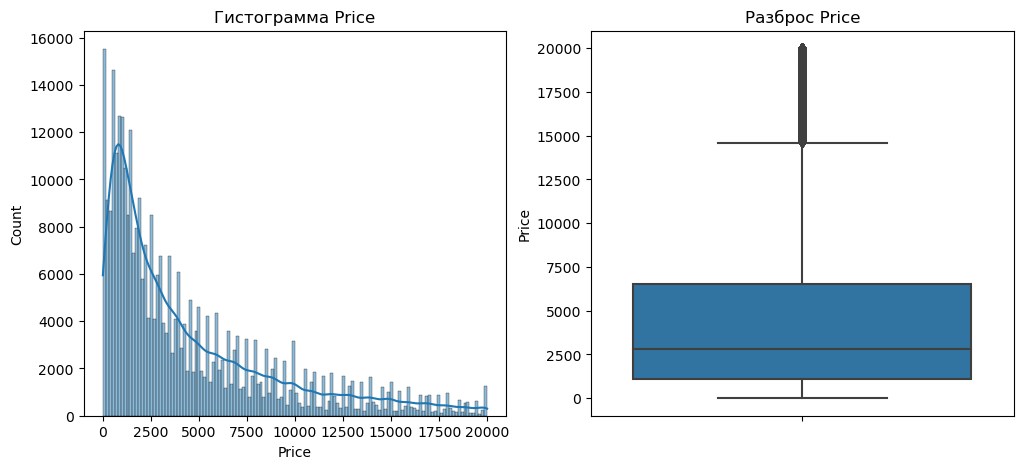

,count,mean,std,min,25%,50%,75%,max
Price,339413.0,4469.917885,4543.710777,0.0,1100.0,2799.0,6500.0,20000.0


Нижняя граница выбросов признака Price: -7000.0
Верхняя граница выбросов признака Price: 14600.0
Количество значений за нижней границей Price: 0


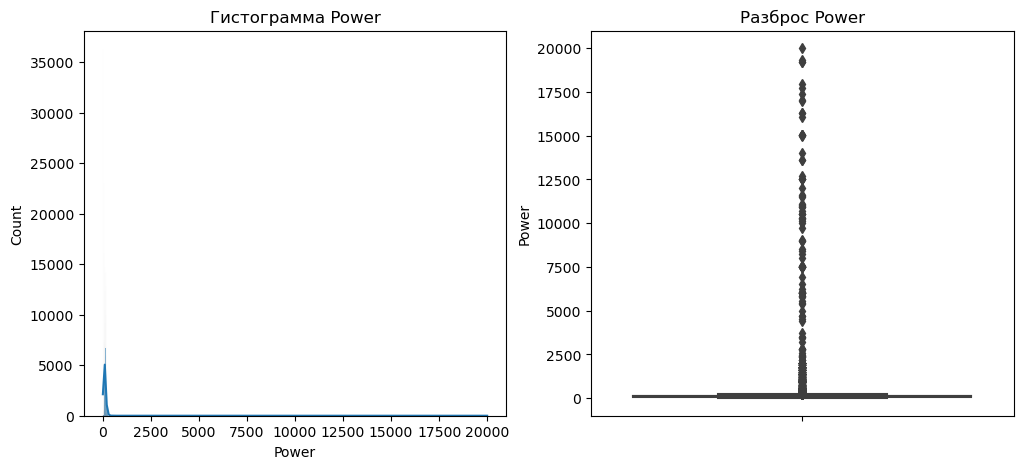

,count,mean,std,min,25%,50%,75%,max
Power,339413.0,111.074809,186.92621,0.0,69.0,105.0,143.0,20000.0


Нижняя граница выбросов признака Power: -42.0
Верхняя граница выбросов признака Power: 254.0
Количество значений за нижней границей Power: 0


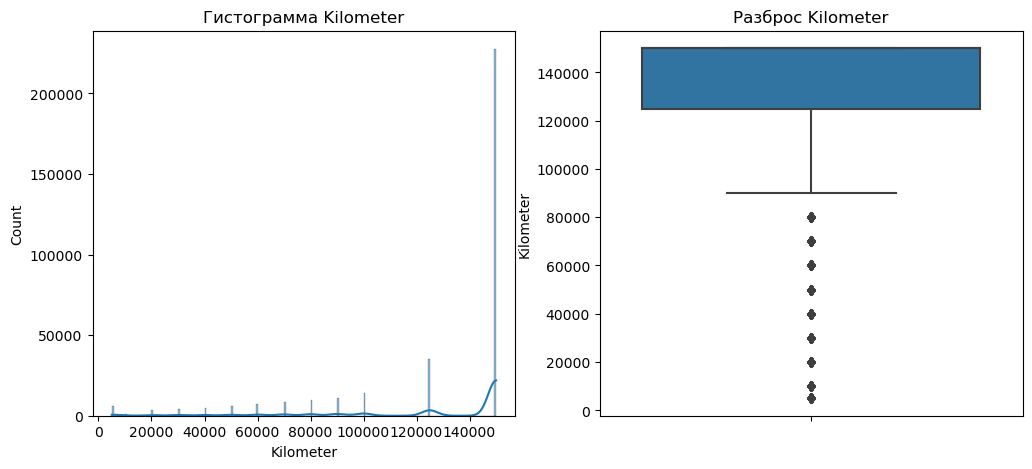

,count,mean,std,min,25%,50%,75%,max
Kilometer,339413.0,128152.840345,37813.33503,5000.0,125000.0,150000.0,150000.0,150000.0


Нижняя граница выбросов признака Kilometer: 87500.0
Верхняя граница выбросов признака Kilometer: 187500.0
Количество значений за нижней границей Kilometer: 51271


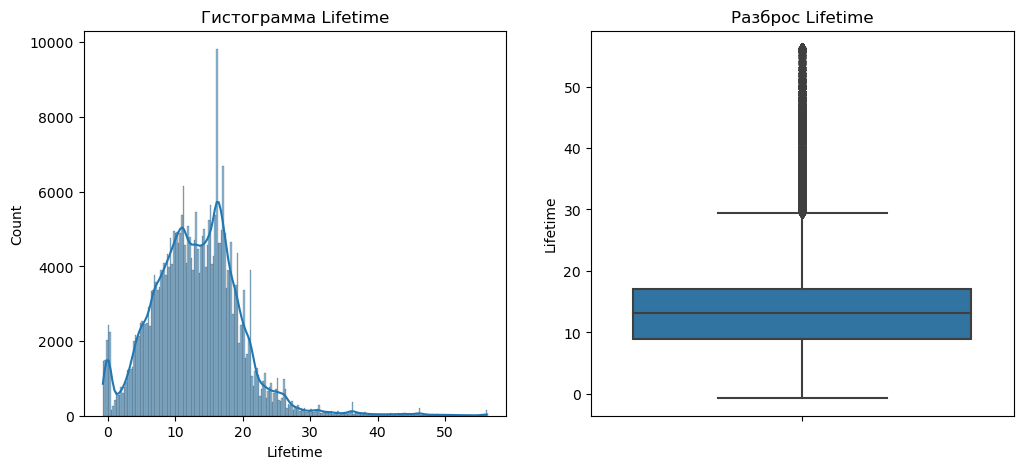

,count,mean,std,min,25%,50%,75%,max
Lifetime,339413.0,13.264855,6.778254,-0.741958,8.826831,13.078713,17.078713,56.262834


Нижняя граница выбросов признака Lifetime: -3.550992470910332
Верхняя граница выбросов признака Lifetime: 29.456536618754274
Количество значений за нижней границей Lifetime: 0


In [12]:
plot_numerical_features(df, numerical_columns_eda)

#### Работа с аномалиями у числовых признаков

__Результаты анализа количественных признаков:__
- Средняя цена 4416 евро, при этом максимальная 20000 евро. Минимальная цена 0. Возможно аномалия, которую нужно исправить
- Судя по графику разброса признака Power 75% значений имеют менее 143 лошадиных сил, при этом есть много аномалий которые стоит определить и удалить.
- Среднее значение километража 128331 км, учитывая, что среди наблюдений есть очень старые машины, то такое вполне вероятно.
- Средний возраст машины 12,6 лет, при этом есть машины которым более 30 лет. Присутствуют аномалии с отрицательным возрастом, их надо удалить

In [13]:
#Определим долю машин с ценой 0
print('Доля цен с 0 значением:', round(df['Price'][df['Price']==0].count() / df['Price'].count(), 2))

Доля цен с 0 значением: 0.03


Доля наблюдений где значение цены 0 незначительная, поэтому заменим их на медианное значение.

In [14]:
# Вычисление медианного значения для столбца 'Price'
median_price = df['Price'].median()

# Замена нулевых значений медианным значением
df.loc[df['Price'] == 0, 'Price'] = median_price

# Проверим результат подстановки
df['Price'][df['Price']==0].count()

0

In [15]:
#Для поиска аномалий (выбросов) найдем границы +-1.5 IQR у столбцов
def outlier_treatment(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return lower_range, upper_range

In [16]:
#Примением поиск границ для выброса
print(outlier_treatment(df['Power']))
#Посчитаем сколько наблюдений вне границ выбросов
print(df[(df['Power'] > 254) | (df['Power'] < 0)].count())
#Уберем значения которые выходят за рамки границ
df = df[(df['Power'] <= 254) & (df['Power'] > 0)]
df['Power'].describe()

(-42.0, 254.0)
Price          7105
VehicleType    6903
Gearbox        7012
Power          7105
Model          6587
Kilometer      7105
FuelType       6747
Repaired       6190
Lifetime       7105
dtype: int64


count    296050.000000
mean        116.242604
std          45.846394
min           1.000000
25%          75.000000
50%         110.000000
75%         144.000000
max         254.000000
Name: Power, dtype: float64

In [17]:
#Оставим наблюдения у которых lifetime больше 0
df = df[df['Lifetime'] > 0]

### Анализ категорийных признаков

In [18]:
def plot_top_categories_by_median_price(df, target_column, categoric_columns):
    for column in categoric_columns:
        # Вычисляем медианное значение Price для каждой категории
        median_price_per_category = df.groupby(column)[target_column].median()
        
        # Сортируем категории по медианному значению Price в убывающем порядке
        sorted_categories = median_price_per_category.sort_values(ascending=False)
        
        # Берем топ-10 категорий
        top_10_categories = sorted_categories.head(10)
        
        # Строим график
        plt.figure(figsize=(10, 6))
        top_10_categories.plot(kind='bar', color='skyblue')
        plt.title(f'Top 10 Categories in {column} by Median {target_column}')
        plt.xlabel(column)
        plt.ylabel(f'Median {target_column}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Отображаем таблицу с результатами
        display(top_10_categories.reset_index().rename(columns={target_column: f'Median {target_column}'}))

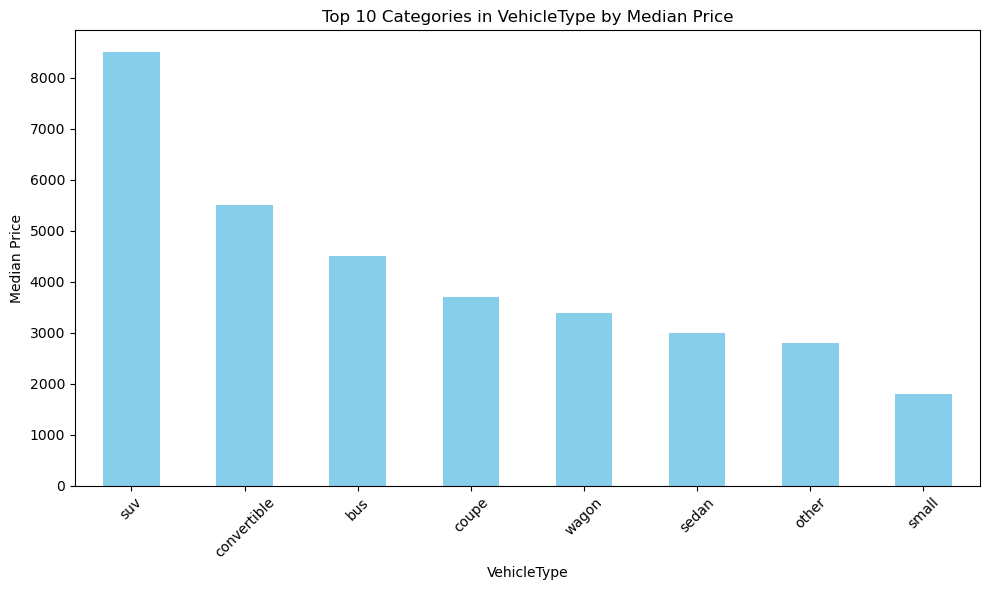

,VehicleType,Median Price
0,suv,8500.0
1,convertible,5500.0
2,bus,4499.0
3,coupe,3700.0
4,wagon,3390.0
5,sedan,3000.0
6,other,2799.0
7,small,1790.0


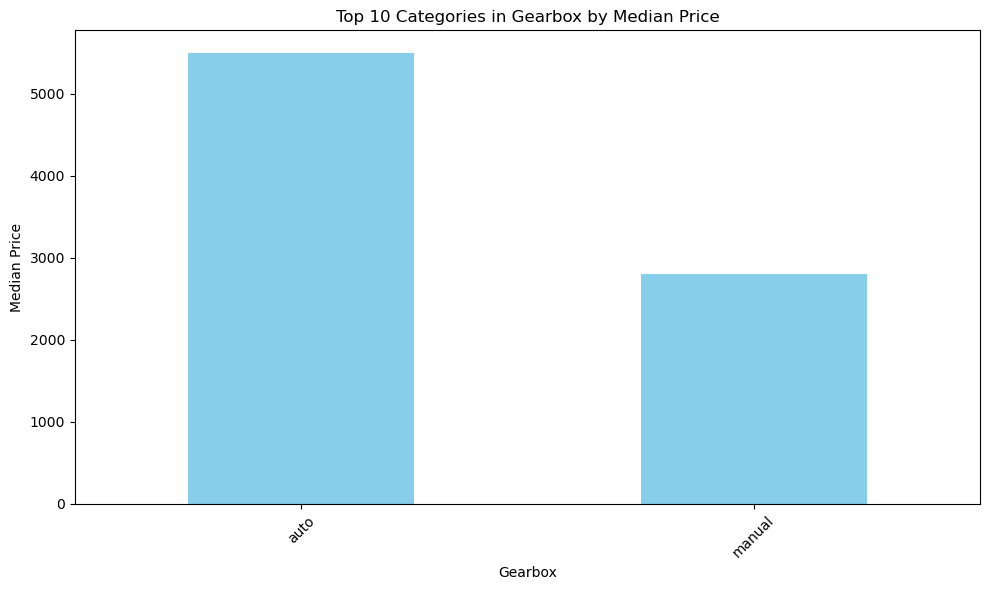

,Gearbox,Median Price
0,auto,5500.0
1,manual,2799.0


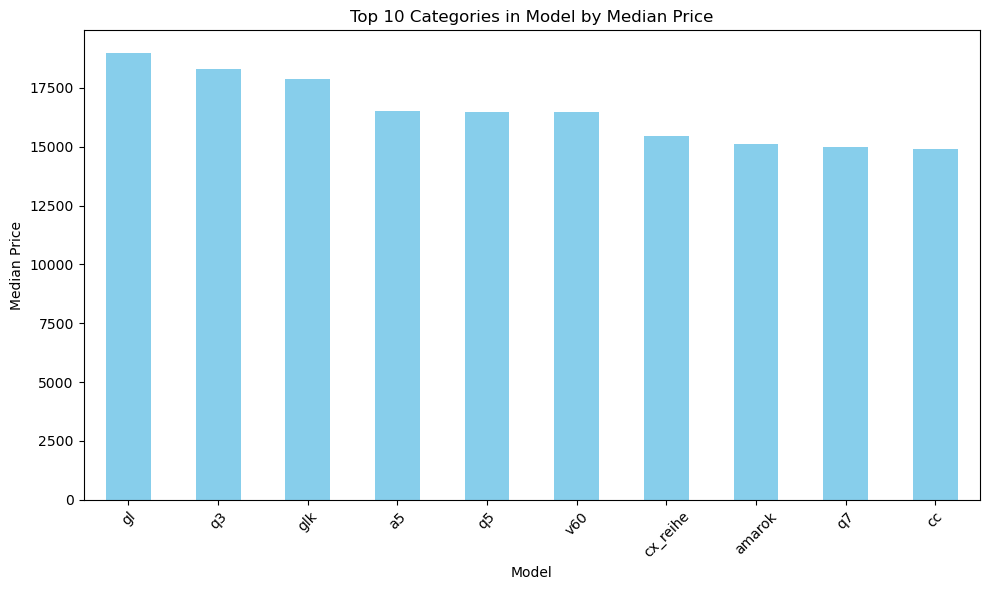

,Model,Median Price
0,gl,18999.0
1,q3,18324.5
2,glk,17900.0
3,a5,16500.0
4,q5,16499.0
5,v60,16495.0
6,cx_reihe,15450.0
7,amarok,15120.0
8,q7,15000.0
9,cc,14900.0


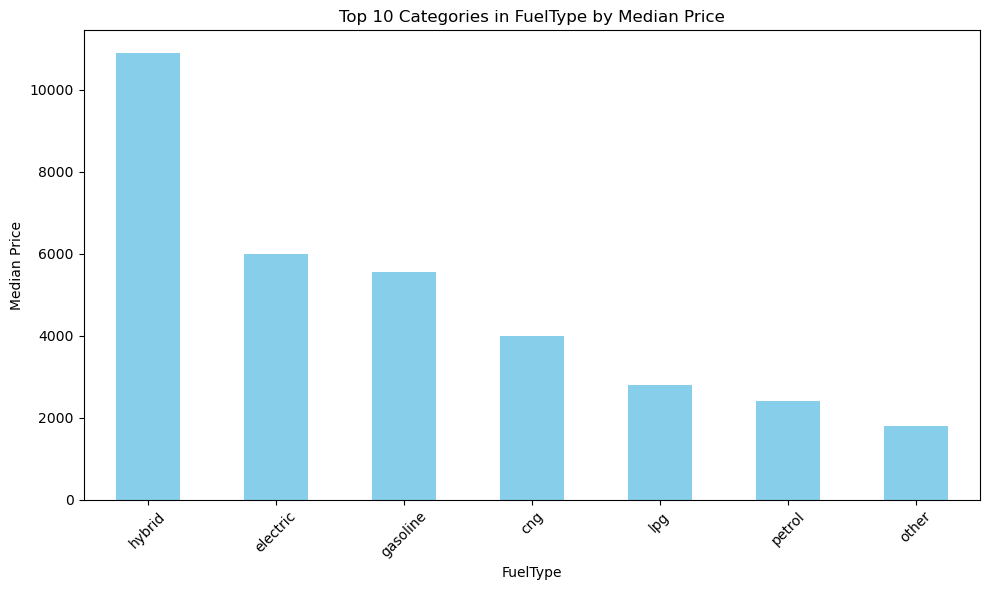

,FuelType,Median Price
0,hybrid,10900.0
1,electric,5999.0
2,gasoline,5550.0
3,cng,3999.0
4,lpg,2800.0
5,petrol,2400.0
6,other,1800.0


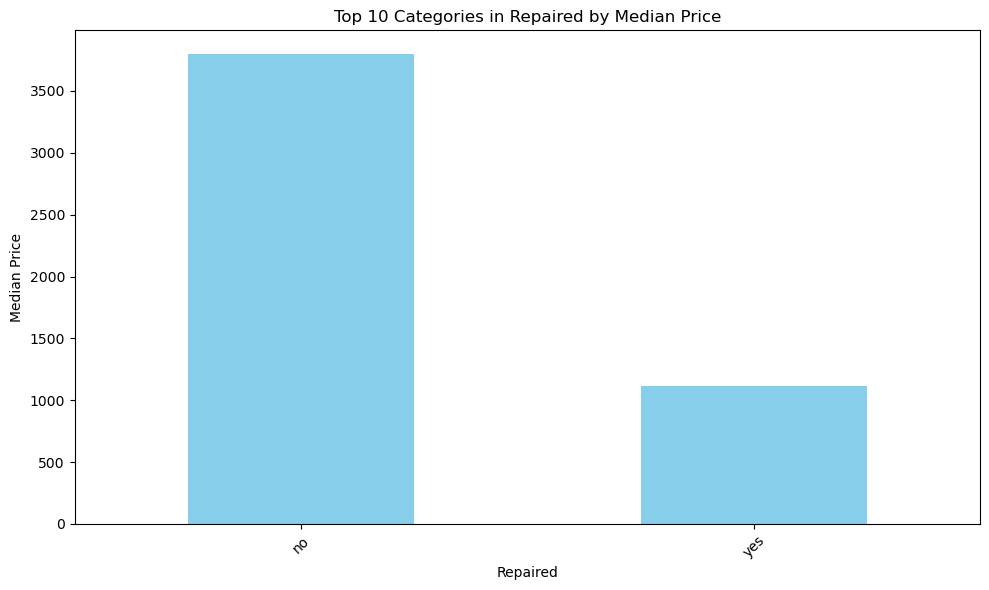

,Repaired,Median Price
0,no,3800.0
1,yes,1111.0


In [19]:
plot_top_categories_by_median_price(df, 'Price', categoric_columns_eda)

#### Корректировка аномалий в категорийных данных

In [20]:
# Замена значений "gasoline" на "petrol" в столбце 'FuelType'
df['FuelType'] = df['FuelType'].replace('gasoline', 'petrol')

__Результаты анализа категорийных признаков:__
- Среди наиболее дорогих моделей авто - SUV, для них медианное значение 8500 евро.
- gl наиболее дорогая модель авто, 19 тысяч евро 
- коробка автомат дороже ручного коробки 5500 vs 2700
- гибриды дороже всего почти вдвое дороже электроавтомобилей
- машины которые не ремонтировались дороже машин после ремонта
- заменили значения gasoline на petrol

### Анализ предподготовленных данных. Оптимизация & проверка мультиколлинеарности. 

In [21]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292123 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Price        292123 non-null  int64  
 1   VehicleType  284182 non-null  object 
 2   Gearbox      286663 non-null  object 
 3   Power        292123 non-null  int64  
 4   Model        281113 non-null  object 
 5   Kilometer    292123 non-null  int64  
 6   FuelType     277403 non-null  object 
 7   Repaired     249198 non-null  object 
 8   Lifetime     292123 non-null  float64
dtypes: float64(1), int64(3), object(5)
memory usage: 22.3+ MB


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Repaired,Lifetime
1,18300,coupe,manual,190,NaN,125000,petrol,yes,4.898015
2,9800,suv,auto,163,grand,125000,petrol,NaN,11.616701
3,1500,small,manual,75,golf,150000,petrol,no,14.792608
4,3600,small,manual,69,fabia,90000,petrol,no,7.748118
5,650,sedan,manual,102,3er,150000,petrol,yes,20.509240


In [22]:
cat_columns = df.select_dtypes(exclude='number').columns.tolist()

# Приведение категориальных признаков к типу category
for col in cat_columns:
    df[col] = df[col].astype('category')

In [23]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [24]:
optimize_memory_usage(df)

Размер использования памяти: до 12.83 Mb - после  7.25 Mb (43.4%)


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Repaired,Lifetime
1,18300,coupe,manual,190,NaN,125000,petrol,yes,4.898015
2,9800,suv,auto,163,grand,125000,petrol,NaN,11.616701
3,1500,small,manual,75,golf,150000,petrol,no,14.792608
4,3600,small,manual,69,fabia,90000,petrol,no,7.748118
5,650,sedan,manual,102,3er,150000,petrol,yes,20.509241
...,...,...,...,...,...,...,...,...,...
354360,3999,wagon,manual,3,3er,150000,petrol,no,10.921287
354362,3200,sedan,manual,225,leon,150000,petrol,yes,11.882273
354366,1199,convertible,auto,101,fortwo,125000,petrol,no,16.010952
354367,9200,bus,manual,102,transporter,150000,petrol,no,20.049282


In [25]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292123 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   Price        292123 non-null  int16   
 1   VehicleType  284182 non-null  category
 2   Gearbox      286663 non-null  category
 3   Power        292123 non-null  int16   
 4   Model        281113 non-null  category
 5   Kilometer    292123 non-null  int32   
 6   FuelType     277403 non-null  category
 7   Repaired     249198 non-null  category
 8   Lifetime     292123 non-null  float32 
dtypes: category(5), float32(1), int16(2), int32(1)
memory usage: 7.3 MB


,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Repaired,Lifetime
1,18300,coupe,manual,190,NaN,125000,petrol,yes,4.898015
2,9800,suv,auto,163,grand,125000,petrol,NaN,11.616701
3,1500,small,manual,75,golf,150000,petrol,no,14.792608
4,3600,small,manual,69,fabia,90000,petrol,no,7.748118
5,650,sedan,manual,102,3er,150000,petrol,yes,20.509241


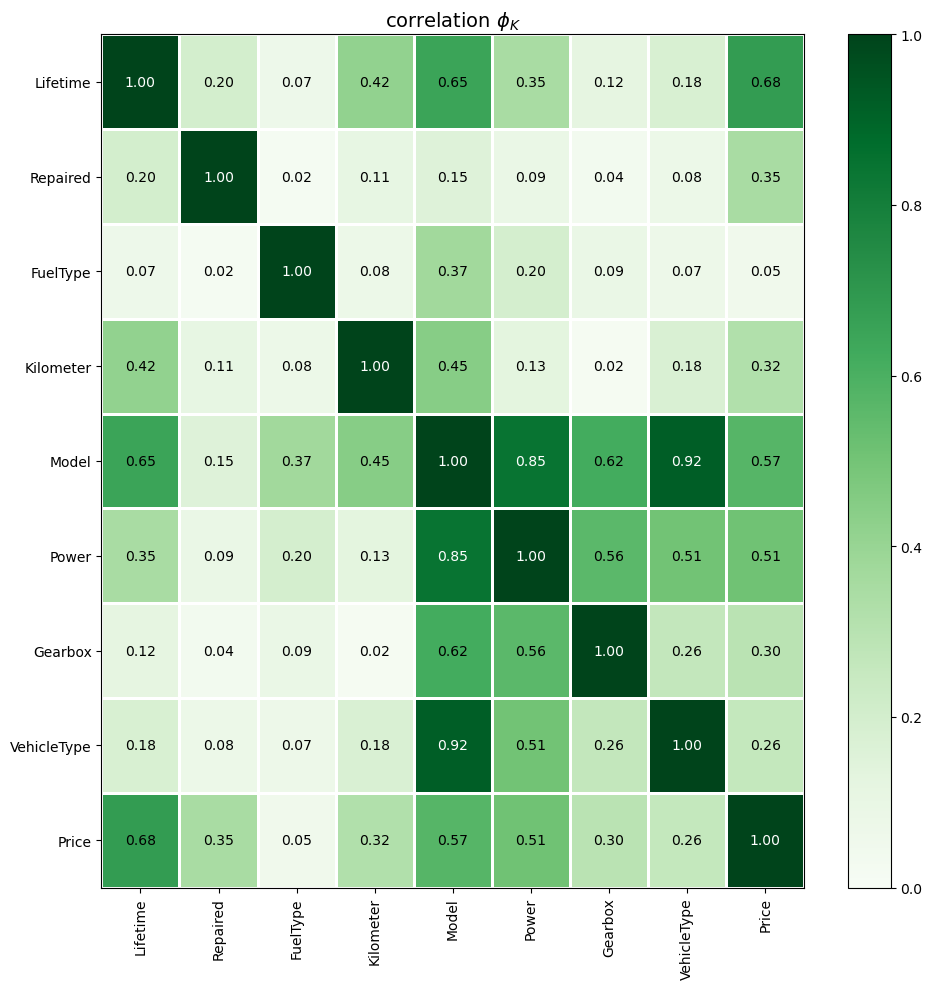

In [26]:
#Обозначим список столбцов с числовыми данными
numerical_columns_corr = df.select_dtypes(include=['number'], exclude=['object']).columns.tolist()

#Изучим корреляцию 
phik_overview = df.phik_matrix(interval_cols=numerical_columns_corr)
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Greens', title=r'correlation $\phi_K$', fontsize_factor=1,
                        figsize=(10,10))
plt.tight_layout()

__Итоги анализа корреляции данных после EDA:__
- 292123 наблюдений после введения корректировок
- Провели оптимизацию размера данных. Размер использования памяти: до 12.83 Mb - после  7.81 Mb (39.1%)
- Корреляционная матрица демонстрирует высокие уровни корреляции для признаков lifetime & model, что может быть обусловлено машинами выпускавшимеся в старые периоды времени. При этом довольно умеренный уровень корреляции между lifetime и целевым признаком.


###  Итоги раздела :
__Итоги загрузки и первичного изучения данных:__ 

- Всего 354369 строк

__Признаки:__

- __DateCrawled__ — дата скачивания анкеты из базы
- __VehicleType__ — тип автомобильного кузова
- __RegistrationYear__ — год регистрации автомобиля
- __Gearbox__ — тип коробки передач
- __Power__ — мощность (л. с.)
- __Model__ — модель автомобиля
- __Kilometer__ — пробег (км)
- __RegistrationMonth__ — месяц регистрации автомобиля
- __FuelType__ — тип топлива
- __Brand__ — марка автомобиля
- __Repaired__ — была машина в ремонте или нет
- __DateCreated__ — дата создания анкеты
- __NumberOfPictures__ — количество фотографий автомобиля
- __PostalCode__ — почтовый индекс владельца анкеты (пользователя)
- __LastSeen__ — дата последней активности пользователя

__Целевой признак:__
- __Price — цена (евро)__

__Выбросы, пропуски и дубликаты:__
- NumberOfPictures состоит из нулевых значений, столбец не несет информационной важности
- Замечены аномалии RegistrationYear, Power
- Пропуски данных в столбцах VehicleType, Gearbox, Model, FuelType, Repaired
- 4 полных дубликата

__Результаты предобработки:__
- Убрано 4 дубликата
- Оставили только машины которые после 1960 и до 2016 года 
- Убрали признаки 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'RegistrationMonth', "Brand", 'RegistrationYear', 'NumberOfPictures', 'RegistrationDate' 

__Результаты анализа и корректировки аномалий количественных признаков:__
- Средняя цена 4416 евро, при этом максимальная 20000 евро. Минимальная цена 0. Возможно аномалия, которую нужно исправить
- Судя по графику разброса признака Power 75% значений имеют менее 143 лошадиных сил, при этом есть много аномалий которые стоит определить и удалить.
- Среднее значение километража 128331 км, учитывая, что среди наблюдений есть очень старые машины, то такое вполне вероятно.
- Средний возраст машины 12,6 лет, при этом есть машины которым более 30 лет. Присутствуют аномалии с отрицательным возрастом, их надо удалить
- Заменили нулевые значения стоимости машин на медианные
- Убрали значения аномальные значения в категории power
- Исключили наблюдения с отрицательным lifetime

__Результаты анализа и корректировки аномалий категорийных признаков:__
- Среди наиболее дорогих моделей авто - SUV, для них медианное значение 8500 евро.
- gl наиболее дорогая модель авто, 19 тысяч евро 
- коробка автомат дороже ручного коробки 5500 vs 2700
- гибриды дороже всего почти вдвое дороже электроавтомобилей
- машины которые не ремонтировались дороже машин после ремонта
- в столбце FuelType заменили значения gasoline на petrol


__Итоги анализа корреляции данных после EDA:__
- 292123 наблюдений осталось после проведения корректировок
- Провели оптимизацию размера данных. Размер использования памяти: до 22.29 Mb - после 17.27 Mb (22.5%)
- Корреляционная матрица демонстрирует высокие уровни корреляции для признаков vehicle type & model, что может быть обусловлено модельным рядом марки




## Обучение моделей

### Подготовка пайплайна

In [27]:
X = df.drop(['Price'], axis=1)
y = df['Price']

#Разделения данных на обучающую выборку и тестовую выборку 
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)

X_train.shape, X_test.shape

((219092, 8), (73031, 8))

In [28]:
ohe_columns = cat_columns.copy()
num_columns = X_train.select_dtypes(exclude='category').columns.tolist()

print('ohe_columns:', ohe_columns)
print('num_columns:', num_columns)

ohe_columns: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
num_columns: ['Power', 'Kilometer', 'Lifetime']


In [29]:
ord_columns = cat_columns.copy()
print('ord_columns:', ord_columns)

# Сбор уникальных категорий для каждого столбца
unique_categories = [X_train[col].dropna().unique().tolist() for col in ord_columns]
print('unique_categories:', unique_categories)

ord_columns: ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
unique_categories: [['wagon', 'bus', 'small', 'sedan', 'suv', 'other', 'convertible', 'coupe'], ['manual', 'auto'], ['astra', 'roomster', 'cordoba', 'e_klasse', 'golf', 'forester', 'omega', 'polo', 'other', '147', 'altea', 'fortwo', 'colt', '3er', 'zafira', 'transporter', 'a6', 'corsa', 'a_klasse', 'leon', 'tucson', 'berlingo', '500', 'a4', 'ka', 'lupo', 'focus', 'galaxy', 'passat', 'seicento', '3_reihe', 'discovery', 'twingo', 'slk', 'insignia', '5er', 'ibiza', 'touran', 'panda', 'v50', '1er', 'megane', 'toledo', '4_reihe', 'carisma', 'i_reihe', 'punto', 'cooper', '2_reihe', 'caddy', 'c_klasse', '80', 'mondeo', 'voyager', 'fiesta', 'swift', 'kuga', 'sharan', 'up', 'a3', 'laguna', 'clubman', 'v_klasse', 'transit', 'phaeton', 'micra', 'c2', '1_reihe', 'bora', 'beetle', 'jetta', 'm_klasse', 'yaris', 'ducato', 'mx_reihe', 'kangoo', 'b_klasse', 'z_reihe', 'c5', '5_reihe', 'arosa', 'xc_reihe', 'fabia', '6_reihe', 'crom

In [30]:
#Пайплайн для подготовки категорийных признаков под модель LinearRegression
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown= 'error', sparse_output=False)
        )
    ]
)

# Пайплайн для подготовки категорийных признаков под модель DecissionTree
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=unique_categories,
                           handle_unknown='use_encoded_value', unknown_value=-1)
        )
    ]
)

# Пайплайн для подготовки пропущенных категорий для модели LightGBM
imput_pipe = Pipeline(
    [
        (
            'simpleImputer', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [31]:
#Пайплайн для подготовки данных с OneHotEncoder для модели LinearRegression
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

# Пайплайн для подготовки данных с OrdinalEncoder для модели DecisionTreeRegressor
data_preprocessor_ord = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns)
    ],
    remainder='passthrough'
)

In [32]:
#Итоговый пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', 'passthrough'),
        ('models', LinearRegression())
    ]
)

# Словарь гиперпараметров моделей
parameters = [
    # Словарь для модели DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 12),
        'models__max_features': range(0, 7),
        'preprocessor': [data_preprocessor_ord]
    },
    # Словарь для модели LinearRegression
    {
        'models': [LinearRegression()],
        'preprocessor': [data_preprocessor]
    },
    # Словарь для модели LGBMRegressor
    {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__num_leaves': range(1, 70),
        'models__n_estimators': range(100, 500),
        'preprocessor': ['passthrough']
    }
]

In [33]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)


randomized_search = RandomizedSearchCV(
    pipe_final, 
    parameters, 
    scoring = rmse_scorer, 
    random_state=RANDOM_STATE, 
    n_jobs=-1
)

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219092 entries, 138275 to 147876
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   VehicleType  213093 non-null  category
 1   Gearbox      214972 non-null  category
 2   Power        219092 non-null  int16   
 3   Model        210849 non-null  category
 4   Kilometer    219092 non-null  int32   
 5   FuelType     208087 non-null  category
 6   Repaired     187008 non-null  category
 7   Lifetime     219092 non-null  float32 
dtypes: category(5), float32(1), int16(1), int32(1)
memory usage: 5.0 MB


In [35]:
%%time
randomized_search.fit(X_train, y_train)

CPU times: user 21.5 s, sys: 4.02 s, total: 25.5 s
Wall time: 26 s


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor', 'passthrough'),
                                             ('models', LinearRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(1, 12),
                                         'models__max_features': range(0, 7),
                                         'preprocessor': [ColumnTransformer(remainder='passthrough',
                                                                            transformers=[('ord',
                                                                                           Pipeline(steps=...
                                                                                            'Model',
                                                                                            'FuelType',
                                                                                            'Repaired']),
                                                                                          ('num',
                                                                                           MinMaxScaler(),
                                                                                           ['Power',
                                                                                            'Kilometer',
                                                                                            'Lifetime'])])]},
                                        {'models': [LGBMRegressor(random_state=42)],
                                         'models__n_estimators': range(100, 500),
                                         'models__num_leaves': range(1, 70),
                                         'preprocessor': ['passthrough']}],
                   random_state=42,
                   scoring=make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict'))

In [36]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor', 'passthrough'),
                ('models',
                 LGBMRegressor(n_estimators=441, num_leaves=48,
                               random_state=42))])
Метрика лучшей модели на кросс-валидации: -1548.6692335606485


__Результаты обучения:__
- Обучение моделей заняло 25 секунд
- Лучшая модель LGBMRegressor(n_estimators=441, num_leaves=48, random_state=42))])
- Метрика RMSE на лучшей модели 1548

## Анализ моделей

In [37]:
pd.set_option('display.max_colwidth', None)

result = pd.DataFrame(randomized_search.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head()) 

,rank_test_score,param_models,mean_test_score,params
0,1,LGBMRegressor(random_state=42),-1548.669234,"{'preprocessor': 'passthrough', 'models__num_leaves': 48, 'models__n_estimators': 441, 'models': LGBMRegressor(random_state=42)}"
1,2,LGBMRegressor(random_state=42),-1551.250089,"{'preprocessor': 'passthrough', 'models__num_leaves': 55, 'models__n_estimators': 327, 'models': LGBMRegressor(random_state=42)}"
4,3,LGBMRegressor(random_state=42),-1555.162652,"{'preprocessor': 'passthrough', 'models__num_leaves': 39, 'models__n_estimators': 411, 'models': LGBMRegressor(random_state=42)}"
3,4,LGBMRegressor(random_state=42),-1560.507469,"{'preprocessor': 'passthrough', 'models__num_leaves': 69, 'models__n_estimators': 176, 'models': LGBMRegressor(random_state=42)}"
7,5,LGBMRegressor(random_state=42),-1564.029659,"{'preprocessor': 'passthrough', 'models__num_leaves': 30, 'models__n_estimators': 419, 'models': LGBMRegressor(random_state=42)}"


In [38]:
%%time

#Подготовим предсказания
y_pred = randomized_search.predict(X_test)
print("RMSE:", root_mean_squared_error(y_test, y_pred))

RMSE: 1534.66128568504
CPU times: user 1.95 s, sys: 47.5 ms, total: 2 s
Wall time: 347 ms


__Результат тестирования:__
- Результат тестирования на лучшей модели RMSE - 1534, что удовлетворяет требованию заказчика
- Время работы 2 сек

## Анализ важности признаков

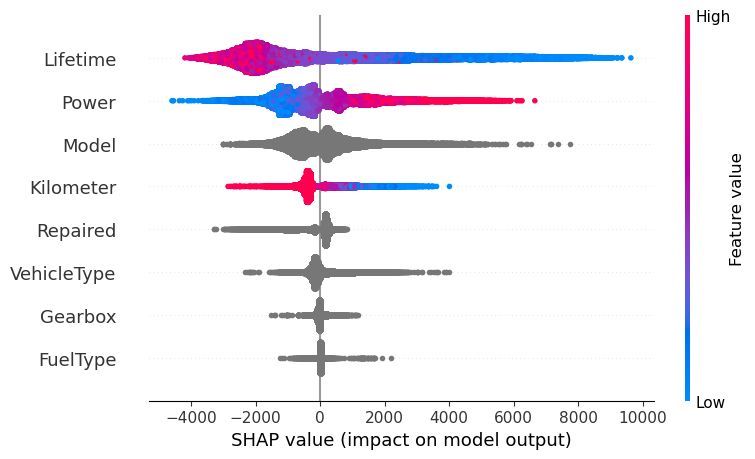

In [39]:
feature_names = X_test.columns

# Инициализация explainer с параметром feature_perturbation
explainer = shap.TreeExplainer(randomized_search.best_estimator_.named_steps['models'], feature_perturbation="tree_path_dependent")

# Получение SHAP значений
shap_values = explainer.shap_values(X_test)

# Преобразование в объект Explanation
shap_values_exp = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X_test, feature_names=feature_names)

# Визуализация
shap.summary_plot(shap_values_exp, X_test)

__Результаты анализа влияния признаков:__
- Чем старее машина, тем ниже стоимость
- Высокая мощность машины повышает цену
- Чем больше километраж на машине, тем ниже цена 

##  Результаты проекта

###  Итоги раздела :
__Итоги загрузки и первичного изучения данных:__ 

- Всего 354369 строк

__Признаки:__

- __DateCrawled__ — дата скачивания анкеты из базы
- __VehicleType__ — тип автомобильного кузова
- __RegistrationYear__ — год регистрации автомобиля
- __Gearbox__ — тип коробки передач
- __Power__ — мощность (л. с.)
- __Model__ — модель автомобиля
- __Kilometer__ — пробег (км)
- __RegistrationMonth__ — месяц регистрации автомобиля
- __FuelType__ — тип топлива
- __Brand__ — марка автомобиля
- __Repaired__ — была машина в ремонте или нет
- __DateCreated__ — дата создания анкеты
- __NumberOfPictures__ — количество фотографий автомобиля
- __PostalCode__ — почтовый индекс владельца анкеты (пользователя)
- __LastSeen__ — дата последней активности пользователя

__Целевой признак:__
- __Price — цена (евро)__

__Выбросы, пропуски и дубликаты:__
- NumberOfPictures состоит из нулевых значений, столбец не несет информационной важности
- Замечены аномалии RegistrationYear, Power
- Пропуски данных в столбцах VehicleType, Gearbox, Model, FuelType, Repaired
- 4 полных дубликата

__Результаты предобработки:__
- Убрано 4 дубликата
- Оставили только машины которые после 1960 и до 2016 года 
- Убрали признаки 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'RegistrationMonth', "Brand", 'RegistrationYear', 'NumberOfPictures', 'RegistrationDate' 

__Результаты анализа и корректировки аномалий количественных признаков:__
- Средняя цена 4416 евро, при этом максимальная 20000 евро. Минимальная цена 0. Возможно аномалия, которую нужно исправить
- Судя по графику разброса признака Power 75% значений имеют менее 143 лошадиных сил, при этом есть много аномалий которые стоит определить и удалить.
- Среднее значение километража 128331 км, учитывая, что среди наблюдений есть очень старые машины, то такое вполне вероятно.
- Средний возраст машины 12,6 лет, при этом есть машины которым более 30 лет. Присутствуют аномалии с отрицательным возрастом, их надо удалить
- Заменили нулевые значения стоимости машин на медианные
- Убрали значения аномальные значения в категории power
- Исключили наблюдения с отрицательным lifetime

__Результаты анализа и корректировки аномалий категорийных признаков:__
- Среди наиболее дорогих моделей авто - SUV, для них медианное значение 8500 евро.
- gl наиболее дорогая модель авто, 19 тысяч евро 
- коробка автомат дороже ручного коробки 5500 vs 2700
- гибриды дороже всего почти вдвое дороже электроавтомобилей
- машины которые не ремонтировались дороже машин после ремонта
- в столбце FuelType заменили значения gasoline на petrol


__Итоги анализа корреляции данных после EDA:__
- 292123 наблюдений осталось после проведения корректировок
- Провели оптимизацию размера данных. Размер использования памяти: до 12.83 Mb - после  7.81 Mb (39.1%)
- Корреляционная матрица демонстрирует высокие уровни корреляции для признаков lifetime & model, что может быть обусловлено машинами выпускавшимеся в старые периоды времени. При этом довольно умеренный уровень корреляции между lifetime и целевым признаком.

__Результаты обучения:__
- Обучение моделей заняло 16 минут
- Лучшая модель LGBMRegressor(n_estimators=441, num_leaves=48, random_state=42))])
- Метрика RMSE на лучшей модели 1548

__Результат тестирования:__
- Результат тестирования на лучшей модели RMSE - 1534, что удовлетворяет требованию заказчика
- Время работы 2.58 сек

__Результаты анализа влияния признаков:__
- Чем старее машина, тем ниже стоимость
- Высокая мощность машины повышает цену
- Чем больше километраж на машине, тем ниже цена 

